In [1]:
from pprint import pprint
import requests
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
def std(array):
    n = len(array)
    mean = sum(array) / n
    return math.sqrt(sum(map(lambda x: math.pow(x - mean, 2), array)) / n)

def pnorm(x):
    q = math.erf(x / math.sqrt(2.0))
    return (1.0 + q) / 2.0

In [140]:
api_url = "http://auctions11.usydrobotics.club/api/fullLogs/"

log_names = eval(requests.request("GET", api_url + "stat").content)

logs = []

for i, name in enumerate(sorted(log_names, key=lambda s: s[:-4].split('_')[-1])[-1000:]):
    log = requests.request("GET", api_url + name).content.strip()
    log = iter([comp for comp in log.split(b'/') if comp])
    teams = eval(next(log))
    bots, tv_mean, tv_std, phase = next(log).split(b'|')
    bots = bots.split(b',')
    tv_mean, tv_std = int(tv_mean), int(tv_std)
    
    game = {
        "name": name,
        "teams": teams,
        "bots": bots,
        "tv_mean": tv_mean,
        "tv_std": tv_std,
        "phase": phase,
        "auctions": []
    }
    for chunks in log:
        auction = {
            "tv": 0,
            "know": [],
            "bids": []
        }

        for chunk in chunks.split(b'|'):
            if chunk.startswith(b't:'):
                auction["tv"] = int(chunk.split(b':')[1])
            elif chunk.startswith(b'k:'):
                auction["know"].append(int(chunk.split(b':')[1]))
            elif chunk.startswith(b'r:'):
                pass
            elif chunk.startswith(b's:'):
                pass
            elif chunk.startswith(b'R:'):
                pass
            elif chunk.startswith(b'S:'):
                pass
            elif chunk.startswith(b'B:'):
                pass
            elif chunk.startswith(b'T:'):
                pass
            else:
                auction["bids"].append(tuple(map(int, chunk.split(b':'))))
        game["auctions"].append(auction)
    
    logs.append(game)

0.003662958601422126


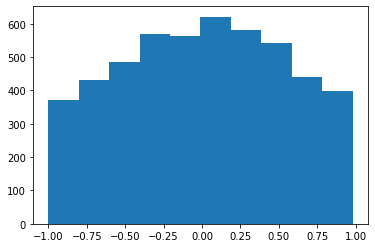

In [8]:
z_scores = []
for game in logs:
    for auction in game["auctions"]:
        z_scores.append((auction["tv"] - game["tv_mean"]) / game["tv_std"])

print(np.mean(z_scores))
plt.hist(z_scores)
plt.show()

40
164.0
2.0
57.0


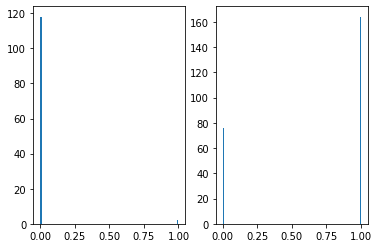

In [216]:
stage_prob = {
    "low": 0.64,
    "mid": 0.16,
    "high": 0.04
}

def get_stage(value, mean):
    if value > mean * 3 / 4:
        return "high"
    elif value > mean / 4:
        return "mid"
    else:
        return "low"

npc_p_values = []
player_p_values = []

game_count = 0
for game_index, game in enumerate(logs):
    if game["phase"] != b"phase_1":
        continue

    tv_mean = game["tv_mean"]

    counts = {"low": 0, "mid": 0, "high": 0}
    bid_counts = [counts.copy() for _ in range(12)]
    round_counts = [counts.copy() for _ in range(12)]
    inc_sums = [0 for _ in range(12)]

    for auction in game["auctions"]:
        last_bid_index = 0
        last_bid = 1
        for who, bid in auction["bids"]:
            stage = get_stage(last_bid, tv_mean)
            bid_counts[who][stage] += 1
            while last_bid_index != who:
                last_bid_index += 1
                if last_bid_index == 12:
                    last_bid_index = 0
                round_counts[last_bid_index][stage] += 1
            inc_sums[who] += bid - last_bid - 8
            last_bid = bid

    if "CHRISTIE" not in game["teams"]:
        continue

    game_count += 1

    for i in range(12):
        test_stats = []
        # perform hypothesis testing on bidding probability
        test_stats = []  # store test statistic and weight (w = 1/sd)
        for stage, prob in stage_prob.items():
            if round_counts[i][stage] == 0:
                continue
            x = bid_counts[i][stage] / round_counts[i][stage]
            sd = math.sqrt(prob * (1 - prob) / round_counts[i][stage])
            test_stats.append(((x - prob) / sd, 1))
        # preform additional testing on bidding increment in phase 2 games
        if game["phase"] == b"phase_2" and sum(bid_counts[i].values()) != 0:
            x = inc_sums[i] / sum(bid_counts[i].values()) / 8
            sd = 7  # / self.engine.math.sqrt(sum(self.bid_counts[i]))
            test_stats.append((x / sd, 1))
        # merge z-scores using weighted method
        final_test_stat = sum(map(lambda ts: ts[0] * ts[1], test_stats)) / \
                          math.sqrt(sum(map(lambda ts: ts[1] ** 2, test_stats)))
        # obtain p-value with normal distribution probability function
        p_value = 2 * pnorm(-abs(final_test_stat))
        if game["phase"] == b"phase_1":
            judge = p_value < 1e-3
        else:
            judge = p_value < 7.5e-6
        if game["bots"][i] == b"NPC":
            npc_p_values.append(float(judge))
        elif game["bots"][i] != b"CHRISTIE":
            player_p_values.append(float(judge))

print(game_count)
print(sum(player_p_values))
print(sum(npc_p_values))
print((sum(npc_p_values) * -90
      + sum(player_p_values) * 15) / game_count)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(npc_p_values, bins=100)
ax2.hist(player_p_values, bins=100)
plt.show()

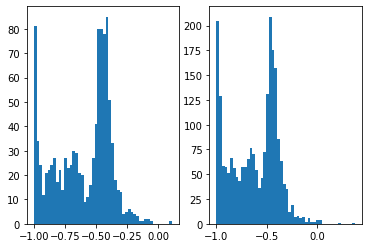

In [137]:
# true value
stage_prob = {
    "low": 0.64,
    "mid": 0.16,
    "high": 0.04
}

def get_stage(value, mean):
    if value > mean * 3 / 4:
        return "high"
    elif value > mean / 4:
        return "mid"
    else:
        return "low"

know_values = []
unknow_values = []

found = []
total = 0

for game_index, game in enumerate(logs):
    game_count += 1

    tv_mean = game["tv_mean"]

    counts = {"low": 1, "mid": 1, "high": 1}
    bid_counts = [counts.copy() for _ in range(12)]
    round_counts = [counts.copy() for _ in range(12)]
    last_bids = [0 for _ in range(12)]
    inc_sums = [[] for _ in range(12)]

    for auction in game["auctions"]:
        last_bid_index = 0
        last_bid = 1
        for who, bid in auction["bids"]:
            stage = get_stage(last_bid, tv_mean)
            bid_counts[who][stage] += 1
            last_bids[who] = bid
            while last_bid_index != who:
                last_bid_index += 1
                if last_bid_index == 12:
                    last_bid_index = 0
                round_counts[last_bid_index][stage] += 1
            inc_sums[who].append(bid)
            last_bid = bid

        if "CHRISTIE" not in game["teams"]:
            continue

        # threshold = 58 if game["phase"] == b"phase_1" else 8
        # stops = [abs(auction["tv"] - bid - threshold) for bid in last_bids]
        # known_bot = sorted(range(12), key=lambda i: stops[i])[:3]

        # found.append(sum(bot in auction["know"] for bot in known_bot))

        for i in range(12):
            x = (sum(inc_sums[i]) / sum(bid_counts[i].values()) - auction["tv"]) / auction["tv"]

            if game["bots"][i] != b"NPC":
                if i in auction["know"]:
                    know_values.append(x)
                else:
                    unknow_values.append(x)

# print(np.mean(found))
#
# plt.hist(found)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(know_values, bins=50)
ax2.hist(unknow_values, bins=50)
plt.show()